In [154]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from math import *
import sys
from skimage import io
from time import clock,time
import pandas as pd
from scipy import optimize
from scipy import integrate
from scipy.integrate import odeint
from scipy.linalg import eig
from scipy.linalg import leslie
import pandas as pd

# Leslie Matrix

In [155]:
data = pd.read_csv("data/YearAgePopBirthDeathData.csv")

In [174]:
y2015 = data[data['YEAR'] == 1990]

In [175]:
# Bins need to be divided into 5-year chunks
population = y2015['POPULATION'].values
birth = y2015['BIRTH RATE'].values
death = y2015['DEATH RATE'].values
bucket_population = [population[0]]
birth_rates = [birth[0]]
death_rates = [death[0]]
for i,p in enumerate(population[1:]):
    
    # In each half-bucket, place half of the population, and assume the birth rates are the same in the two half-buckets
    half = int(p/2)
    bucket_population.append(half)
    bucket_population.append(half)
    
    birth_rates.append(birth[i])
    birth_rates.append(birth[i])
    
    death_rates.append(death[i])
    death_rates.append(death[i])


In [176]:
y2015

,YEAR,AGE GROUP,POPULATION,BIRTH RATE,DEATH RATE,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1990,<4,18887075.0,0.0000,0.003161,NaN,NaN,NaN,NaN,NaN
1,1990,5-14,35360381.0,0.0014,0.000175,NaN,NaN,NaN,NaN,NaN
2,1990,15-24,36193896.0,0.0882,0.000526,NaN,NaN,NaN,NaN,NaN
3,1990,25-34,42574509.0,0.1005,0.001034,NaN,NaN,NaN,NaN,NaN
4,1990,35-44,37649458.0,0.0186,0.002296,NaN,NaN,NaN,NaN,NaN
5,1990,45-54,25242747.0,0.0002,0.005383,NaN,NaN,NaN,NaN,NaN
6,1990,55-64,21096727.0,0.0000,0.010976,NaN,NaN,NaN,NaN,NaN
7,1990,65-74,18121686.0,0.0000,0.022607,NaN,NaN,NaN,NaN,NaN
8,1990,75+,13181238.0,0.0000,0.149377,NaN,NaN,NaN,NaN,NaN


In [177]:
# age intervals
age_upper = [
    4,
    9,
    14,
    19,
    24,
    19,
    34,
    39,
    44,
    49,
    54,
    59,
    64,
    69,
    74,
    79,
]
# birth rates
a = np.array(birth_rates)*5

# survival rates
b = 1 - y2015['DEATH RATE'].astype('float32').values[:-1]

b = 1 - np.array(death_rates[:-1])
leslie_mat = leslie(a,b)
leslie_mat

array([[ 0.        ,  0.        ,  0.        ,  0.007     ,  0.007     ,
         0.441     ,  0.441     ,  0.5025    ,  0.5025    ,  0.093     ,
         0.093     ,  0.001     ,  0.001     ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.9968385 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.9968385 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.9968385 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        

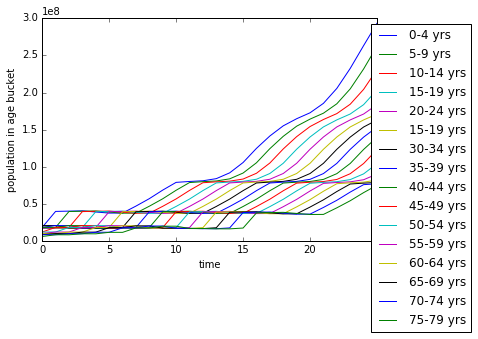

In [189]:
# plot projections for future years
P = [np.array(bucket_population)]
tToPlot = range(26)

for _ in range(1,26):
    P.append(np.dot(leslie_mat,P[-1]))

for age_itvl in range(len(age_upper)):
    plt.plot(tToPlot, [Pt[age_itvl] for Pt in P], label=str(age_upper[age_itvl]-4)+'-'+str(age_upper[age_itvl]) + " yrs")

plt.legend(bbox_to_anchor=(1.3, 1))
plt.ylabel('population in age bucket')
plt.xlabel('time')
plt.show()

In [182]:
# Print the results to file

lower_yrs = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
upper_yrs = [4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79]

lower_col = []
upper_col = []
for age in lower_yrs:
    lower_col.extend([age]*6)

for age in upper_yrs:
    upper_col.extend([age]*6)

    
years = range(1990, 2016, 5)*len(lower_yrs)
pop = []
age_range = len(lower_yrs)
for a in range(age_range):
#     print [Pt[a] for Pt in P]
    pop.extend([Pt[a] for Pt in P])


print len(years)
print len(pop)
print len(lower_col)
    
df = pd.DataFrame({'Year': years, 'Age_Lower':lower_col, 'Age_Upper':upper_col, 'Population':pop})

96
96
96


In [183]:
df.to_csv("data/leslie_results_1990.csv", sep=',',index=False)

## Eigenvalue Analysis

In [163]:
eigen = eig(leslie_mat)
evals = eigen[0]
evecs = eigen[1]

i = np.argmax(evals)
dominant_eval = evals[i]
norm = abs(evecs[:,i])
composition = norm / max(norm)

print "long term growth rate: %0.6f" % dominant_eval
print "long term composition: ", np.round(composition, 3)

long term growth rate: 1.075876
long term composition:  [ 1.     0.927  0.858  0.795  0.739  0.687  0.638  0.593  0.55   0.511
  0.474  0.44   0.406  0.376  0.345  0.317  0.288]


C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


# Compartmental

In [164]:
# ODE APPROACH CONSTANTS
b = 0.01270
mu = 0.00799
beta = 1/22.0 # working age 
gamma = 1/43.0 
x0 = np.sum(y2015[y2015['AGE GROUP'].isin(['<4', '5-14'])]['POPULATION'].astype('float32').values)
y0 = np.sum(y2015[y2015['AGE GROUP'].isin(['15-24', '25-34', '35-44', '45-54', '55-64'])]['POPULATION'].astype('float32').values)
z0 = np.sum(y2015[y2015['AGE GROUP'].isin(['65-74', '75+'])]['POPULATION'].astype('float32').values)

# For variable birth/death
bs = {'C': 0.0007, 'W':0.0415, 'R':0.0}
mus = {'C':0.0001668, 'W':0.004043, 'R':0.085992}

### Gonzalez-Parra and Arenas Analytical Scaled Solution

In [165]:
# http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S1794-91652014000100003
def C(t):
    b = bs['C']
    mu = mus['C']
    return (b + np.exp(-1*beta*t)*(-1*b + beta*x0)) / beta

def W(t):
    b = bs['W']
    mu = mus['W']
    return ( (b*np.exp(gamma*t)/gamma) + 
        ((-1*b + beta*x0)*np.exp(gamma*t - beta*t)/(gamma - beta)) -
        ((b*beta - gamma*beta*x0 + y0*gamma**2 - y0*gamma*beta)/(gamma*(-1*gamma + beta))) ) * np.exp(-1*gamma*t)

def R(t):
    b = bs['R']
    mu = mus['R']
    t1 = (-1*b*t + (np.exp(-1*beta*t)*(-1*b + beta*x0))/beta ) * (gamma/(-1*gamma + beta))
    t2 =  -1 * (np.exp(-1*gamma*t)*(b*beta - gamma*beta*x0 + y0*gamma**2 - y0*gamma*beta) / (gamma*(-1*gamma + beta))) * (gamma/(-1*gamma + beta))
    t3 = (b*t + (b*beta  - gamma*beta*x0 - y0*gamma*beta - z0*gamma*beta + gamma*b)/(gamma*beta)) * (gamma/(-1*gamma + beta))
    t4 = (np.exp(-1*gamma*t)*(b*beta - gamma*beta*x0 + y0*gamma**2 - y0*gamma*beta) / (gamma*(-1*gamma + beta)) + b*t) * (beta/(-1*gamma + beta))
    t5 = ((-b*beta + gamma*beta*x0 + y0*gamma*beta + z0*gamma*beta - gamma*b)/(gamma*beta) - b*t) * (beta/(-1*gamma + beta))
    return t1 + t2 + t3 + t4 + t5

times = np.linspace(0,26,26)
c = [C(t) for t in times]
w = [W(t) for t in times]
r = [R(t) for t in times]


### Gonzalez-Parra and Arenas Unscaled Solution

In [166]:
def pop_path_unscaled(path,t):
    C,W,R = path
    P=float(C+W+R)
    dcdt = b*P - beta*C
    dwdt = beta*C - gamma*W
    drdt = gamma*W - P*mu
    return [dcdt, dwdt, drdt]

### New ODE - Unscaled

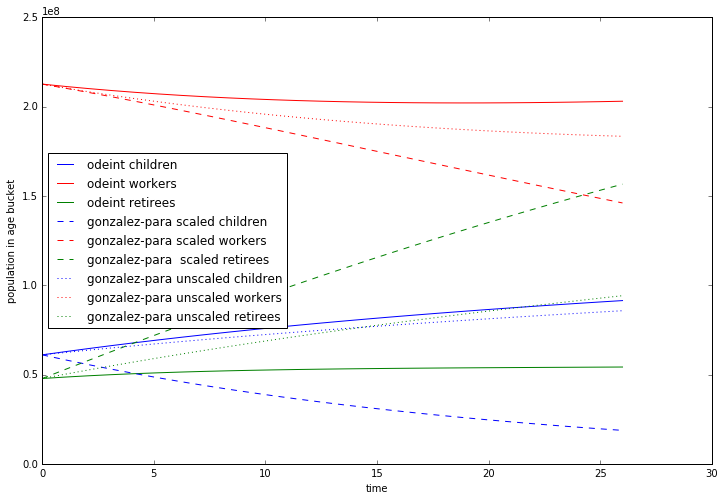

In [171]:
def pop_path(path, t):
    muc = mus['C']
    muw = mus['W']
    mur = mus['R']
    beta = 1/22.0 # working age 
    gamma = 1/43.0 
    b = (bs['C'] + bs['W'] + bs['R']) / 3
    C,W,R = path
    
    dcdt = b*(C + W + R) - (beta - muc)*C
    dwdt = beta*C - (gamma-muw)*W
    drdt = gamma*W - mur*R
    
    return [dcdt, dwdt, drdt]
    

path0 = [x0,y0,z0]

path_out = odeint(pop_path, path0, times)
path_out2 = odeint(pop_path_unscaled, path0, times)

plt.figure(figsize=(12,8));
plt.plot(times,path_out[:,0],label='odeint children', color="blue")
plt.plot(times,path_out[:,1],label='odeint workers', color="red")
plt.plot(times,path_out[:,2],label='odeint retirees', color="green")
plt.plot(times,c, color="blue", label="gonzalez-para scaled children", ls='--')
plt.plot(times,w, color="red", label="gonzalez-para scaled workers", ls='--')
plt.plot(times,r, color="green", label="gonzalez-para  scaled retirees", ls='--')
plt.plot(times,path_out2[:,0], color="blue", label="gonzalez-para unscaled children", ls=':')
plt.plot(times,path_out2[:,1], color="red", label="gonzalez-para unscaled workers", ls=':')
plt.plot(times,path_out2[:,2], color="green", label="gonzalez-para unscaled retirees", ls=':')
plt.legend(loc='best')
plt.ylabel('population in age bucket')
plt.xlabel('time')
plt.show()

In [152]:
# Write results to file
year1 = 2015
n_years = path_out.shape[0]
years = [year1 + i for i in range(n_years)] * 3

pops = list(path_out[:,0])
pops.extend(list(path_out[:,1]))
pops.extend(list(path_out[:,2]))

groups = ['C'] * n_years
groups.extend(['W']*n_years)
groups.extend(['R']*n_years)

df2 = pd.DataFrame({'Year':years, 'Group':groups, 'Population':pops})
df2.to_csv("data/ode_results_2015.csv", sep=',',index=False)

78
26
78


# Death Rates

In [124]:
death = pd.read_csv("data/death.txt", delimiter="\t")

In [125]:
death = death[death["Notes"] != "Total"]
death['DeathRate'] = death['Crude Rate'].values/100000
pert = pd.DataFrame({'Year':death['Year'], 'AgeGroup':death['Ten-Year Age Groups'], 'Population': death['Population'], 'Deaths':death['Deaths'], 'DeathRate': death['DeathRate']})

In [126]:
pert.head()

,AgeGroup,DeathRate,Deaths,Population,Year
0,< 1 year,0.007360,27937,3795762,1999.0
1,< 1 year,0.007367,28035,3805648,2000.0
2,< 1 year,0.006870,27568,4012658,2001.0
3,< 1 year,0.007095,28034,3951461,2002.0
4,< 1 year,0.007049,28025,3975871,2003.0


In [127]:
to_5 = pert[pert['AgeGroup'].isin(['< 1 year', '1-4 years'])]
years = range(1999, 2016)

deaths = []
combined_pop = []
deathrates = []
for year in years:
    pop = np.sum((to_5[to_5['Year'] == year])['Population'])
    death = np.sum((to_5[to_5['Year'] == year])['Deaths'])
    deathrate = death / float(pop)
    deaths.append(death)
    combined_pop.append(pop)
    deathrates.append(deathrate)
    
agegroup = ['0-4']*len(years)
death2 = pd.DataFrame({'AgeGroup': agegroup, 'DeathRate':deathrates, 'Deaths': deaths, 'Population':combined_pop, 'Year':years})

In [129]:
pert = pert[-(pert['AgeGroup'].isin(['< 1 year', '1-4 years']))]
frames = [death2, pert]
result = pd.concat(frames)
result.to_csv('data/death.csv',sep=',',index=False)

In [154]:
result.head()

,AgeGroup,DeathRate,Deaths,Population,Year
0,0-4,0.001734,33186,19135544,1999.0
1,0-4,0.001722,33014,19175798,2000.0
2,0-4,0.001693,32675,19298217,2001.0
3,0-4,0.001693,32892,19429192,2002.0
4,0-4,0.001684,32990,19592446,2003.0


In [155]:
y2015

,YEAR,AGE GROUP,POPULATION,BIRTH RATE,DEATH RATE,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1990,<4,18887075.0,0.0000,0.003161,NaN,NaN,NaN,NaN,NaN
1,1990,5-14,35360381.0,0.0014,0.000175,NaN,NaN,NaN,NaN,NaN
2,1990,15-24,36193896.0,0.0882,0.000526,NaN,NaN,NaN,NaN,NaN
3,1990,25-34,42574509.0,0.1005,0.001034,NaN,NaN,NaN,NaN,NaN
4,1990,35-44,37649458.0,0.0186,0.002296,NaN,NaN,NaN,NaN,NaN
5,1990,45-54,25242747.0,0.0002,0.005383,NaN,NaN,NaN,NaN,NaN
6,1990,55-64,21096727.0,0.0000,0.010976,NaN,NaN,NaN,NaN,NaN
7,1990,65-74,18121686.0,0.0000,0.022607,NaN,NaN,NaN,NaN,NaN
8,1990,75+,13181238.0,0.0000,0.149377,NaN,NaN,NaN,NaN,NaN


In [170]:
y1990 = y2015[y2015['AGE GROUP'] == "<4"]

In [171]:
y1990

,YEAR,AGE GROUP,POPULATION,BIRTH RATE,DEATH RATE,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1990,<4,18887075.0,0.0,0.003161,NaN,NaN,NaN,NaN,NaN
